**MNIST**

We will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau.  

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

Each image has 784 features, because each image is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black)

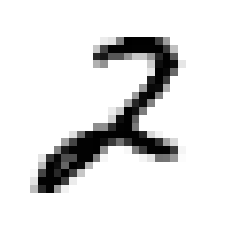

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[36001]
some_digit_image = some_digit.values.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
y[36001]

'2'

Конвертим строки в числа:

In [7]:
import numpy as np

y = y.astype(np.uint8)

The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [8]:
 X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, which is good as this guarantees that all cross-validation folds will be similar

**Binary Classifier**

In [9]:
y_train_2 = (y_train == 2)
y_test_2 = (y_test == 2)

**Stochastic Gradient Descent (SGD)**

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train.values, y_train_2.values)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

**Performance Measures**  
Evaluating a classifier is often significantly trickier than evaluating a regressor

In [12]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(sgd_clf, X_train, y_train_2, cv=3, scoring="accuracy")
scores

array([0.96645, 0.95895, 0.904  ])

In [13]:
sum(scores) / 3

0.9431333333333334

Dumb classifier

In [14]:
from sklearn.base import BaseEstimator

class Never2Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_2_classifier = Never2Classifier()
dump_scores = cross_val_score(never_2_classifier, X_train, y_train_2, cv=3, scoring="accuracy")
dump_scores

array([0.90355, 0.8993 , 0.89925])

In [16]:
sum(dump_scores) / 3

0.9007

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus.

**Precision and Recall**

You first need to have a set of predictions, so they can be compared to the actual targets. You could make predictions on the test set, but let’s keep it untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). Instead, you can use the cross_val_predict() function:

In [17]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_2, cv=3)
y_train_pred

array([False, False, False, ..., False, False, False])

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_2, y_train_pred)

0.6685199894095843

In [19]:
recall_score(y_train_2, y_train_pred)

0.8475998657267539

When it claims an image represents a 2, it is correct only precision_score% of the time. Moreover, it only detects recall_score% of the 2s.

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_2, y_train_pred)

0.7474837181764358

**Precision/Recall Tradeoff**

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([321.32609056])

This time specifying that you want it to return decision scores instead of predictions:

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_2, cv=3,
                                 method="decision_function")
y_scores

array([-36851.09465219, -31272.70892659, -21491.02754016, ...,
       -30052.05804538, -18789.24492043, -20051.24297549])

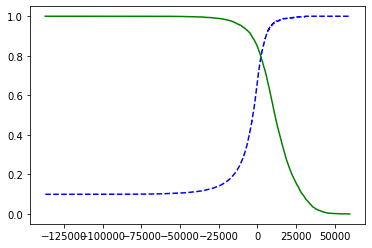

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_2, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()